In [6]:
# f1 scores 

import numpy as np 
import pandas as pd
import pickle
from sklearn.metrics import f1_score
import os

def create_f1(key, th=0.5):

    path = 'data/'
    models = ['CNN', 'MLP']
    leads = [d for d in range(14)]
    quantiles = [0.50, 0.75,  0.9, 0.95]# 0.80, 0.85, 0.9, 0.95]
    threshold = th

    results = {}
    rname = 'results/classifier_outcomes_%s.csv' % key
    outcomes = pd.read_csv(rname, index_col=0, parse_dates=True)


    for q in quantiles:
        results[q] = {}
        try:
            y = outcomes['ERA5_%0.2f' % q]
            y_test = y[3932:] # test only
        except:
            continue

        for m in models:
            f1model = []
            f1modelerr = []
            no_skill = []

            for l in leads:
                col = '%s_%d_%0.2f' % (m, l, q)
                y_pred = outcomes[col]
                y_pred = y_pred[3932:] # test only
                no_skill.append(y_test.sum() / y_test.size)

                # bootstrap
                nboot = 200
                temp = np.zeros(nboot)
                N = y_test.size

                for i in range(nboot):
                    r = np.random.randint(N, size=N)
                    temp[i] = f1_score(y_test[r], (y_pred[r] > threshold))

                f1model.append(np.mean(temp))
                f1modelerr.append(1.96 * np.std(temp, ddof=1)) 
                # how was the error calculated??

            results[q][m] = (f1model, f1modelerr)

    pickle.dump(results, open('results/f1scores_%s.pkl' % (key), 'wb'))  

In [7]:
create_f1('1d_precip_location_final1')

In [8]:
gefs_benchmark = pickle.load(open('results/gefs_benchmark_precip.pkl', 'rb'))
corrected_gefs_benchmark = pickle.load(open('results/gefs_benchmark_precip_apples.pkl', 'rb'))# then plot

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6.5, 4.5]


def plot_f1(key):
    gefs_benchmark = pickle.load(open('results/gefs_benchmark_precip.pkl', 'rb'))
    corrected_gefs_benchmark = pickle.load(open('results/gefs_benchmark_precip_apples.pkl', 'rb'))# then plot
    results = pickle.load(open('results/f1scores_%s.pkl' % key, 'rb'))

#    quantiles = [0.50, 0.75, 0.9, 0.95, 0.80, 0.85, 0.9, 0.95]

    quantiles = [0.50, 0.75, 0.9, 0.95] 
    models = ['CNN', 'MLP']
    leads = [d for d in range(14)]

    for i,q in enumerate(quantiles):
#        plt.subplot(2,3,i+1)

        plt.subplot(2,2,i+1)
        plt.title('quantile %0.2f' % q, fontsize=8)
        no_skill = np.array([(1-q) for d in leads])
        
        plt.plot(np.array(leads)+1, np.array(no_skill), '--', color='0.5', linewidth = 1)
        
        for m in models:
            try:
                f1model, f1modelerr = results[q][m]

                plt.errorbar(x = np.array(leads)+1,
                             y = np.array(f1model),
                             yerr = np.array(f1modelerr),
                             linewidth = 1)
            except:
                continue

        plt.errorbar(x = np.array(leads)+1,
                     y = np.array(gefs_benchmark[q]['f1']), 
                     yerr = np.array(gefs_benchmark[q]['f1_ci']),
                     color='gray',
                     linewidth = 1)  
        

        plt.errorbar(x = np.array(leads)+1,
                     y = np.array(corrected_gefs_benchmark[q]['f1']),
                     yerr = np.array(corrected_gefs_benchmark[q]['f1_ci']),
                     color = 'k',
                     linewidth = 1)
        
        plt.xlabel('Lead time (days)', fontsize=8)
        plt.ylabel('F1 Score', fontsize=8)
        plt.xticks(np.arange(min(leads)+2, max(leads)+2, 2.0), fontsize = 7)
        plt.yticks(fontsize = 7)

        plt.ylim([0,1])

        if i==0:
            plt.ylim([0.2,1])
            plt.legend(['No Skill', 'CNN', 'MLP', 'GEFS', 'bias-corr. GEFS'],
                       ncol=2, loc='lower center', fontsize=7)
        if i==1:
            plt.ylim([0.2,1])

            

    plt.tight_layout()

#    plt.show()

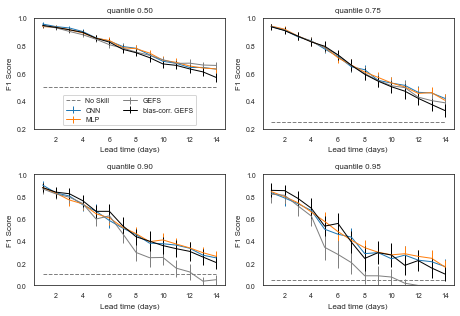

In [11]:
import seaborn as sns
sns.set_style('white')

plot_f1('1d_precip_location_final1')

plt.savefig('/final_figures/4.svg', format='svg', bbox_inches='tight')
plt.savefig('/final_figures/4.png', dpi=300, bbox_inches='tight')
plt.show()